# How to: Use `jackknify` for line finding. 

`jackknify` can be used in a variaty of ways. Here, we show how to use the jackknifed data sets for inference of a line detection. According to JWST data, In the ALMA data we have been working with, there should be [OIII] emission coming from a galaxy which some 14 Billion light years away. Let's see if we can find it, or if it is undistinguishable from noise.

The line finding is done with a code named [Source EXtractor](https://www.astromatic.net/software/sextractor/). Source extractor is integrated in a Python interface through the [`Interferopy` package](https://interferopy.readthedocs.io/en/latest/). Sadly, the combination of `interferopy` and `casatasks` restricts the usage of Python version to Python=3.8. We ran the linefinding seperately, but you can you find the output catalogs also on the [google drive](https://drive.google.com/file/d/1FlQNwy7VtAk0zcFfdW5tMY2aGKivxlyR/view?usp=sharing) and the script we used to generate the outputs in the same folder as the tutorials. 

Let's first load in everything. 

### Load in 

In [1]:
import os
import numpy as np
from scipy import stats
from astropy.io import ascii, fits
from astropy import constants as c
from astropy import units as u
from astropy.modeling import models
from astropy.coordinates import SkyCoord
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
def data(path, positive = True):
    if positive:
        return ascii.read(path+'findlcumps_clumpsP_minSNR_0_cropped.cat')
    if not positive:
        return ascii.read(path+'findlcumps_clumpsN_minSNR_0_cropped.cat')

In [3]:
#noise
galaxy = 'Glass-z13'

outdir = '../../output/findclumps/'
paths  = [outdir+x+'/' for x in os.listdir(outdir) if x.startswith('.') is False]
paths_real = [s for s in paths if 'Jack' not in s]
paths_jack = [s for s in paths if 'Jack' in s]

paths_real = [s for s in paths_real if galaxy in s][0]
paths_jack = [s for s in paths_jack if galaxy in s]

## Plot sampled probabillity functions

As explained in [Vio & Andreani 2016](https://arxiv.org/abs/1602.02392), the underlying distribution that sets the likelihood of false detection is the distribution of peaks of a smoothed (close to) Gaussian random field. With the jackknifed measurment sets we effectively sample this distribution. This is more complete and more acurately than, for isntance, using the distribution of negative peak values as used in [Walter+2016](https://arxiv.org/abs/1607.06768). 

Let's first convert the dataframes to numpy arrays

In [4]:
RAs_real_P   = np.array(data(paths_real)['RA'])
Decs_real_P  = np.array(data(paths_real)['DEC'])
data_real_P  = np.array(data(paths_real)['SNR']) 

In [5]:
RAs_jack  = np.empty(0)
Decs_jack = np.empty(0)
data_jack = np.empty(0)

for idx, path in enumerate(paths_jack):
    RAs_jack  = np.append(RAs_jack,  np.array(data(path)['RA']))
    Decs_jack = np.append(Decs_jack, np.array(data(path)['DEC']))
    data_jack = np.append(data_jack, np.array(data(path)['SNR']))

### Detection inference

Now let's compare the noise distribution --- drawn fromt the jackknifed data sets --- with the positive peak distribution of the real initial data set. Since the astronomical signal is positive, any excess in peaks distribution in the data can be considered real.

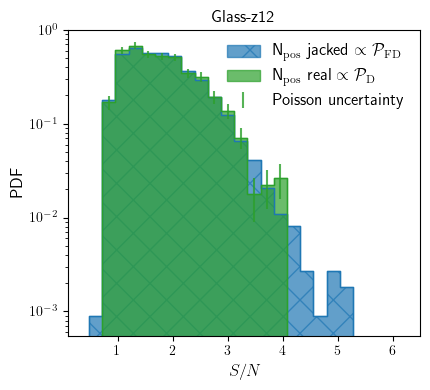

In [6]:
mpl.rcParams['hatch.linewidth'] = 1

# Density vs SNR
# --------------
plt.figure(figsize=(4.4,4))
plt.title('Glass-z12')

# plt.grid(True, alpha = 0.4, lw=1, ls=':')

# plotting the Poisson uncertainty
PTD, bin_edges = np.histogram(data_real_P, bins=np.linspace(0, 6, 26), density = True)
PFD, bin_edges = np.histogram(data_jack,   bins=np.linspace(0, 6, 26), density = True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_widths = bin_edges[1] - bin_edges[0]

raw_counts, _ = np.histogram(data_real_P, bins=np.linspace(0, 6, 26))
uncertainties = np.sqrt(raw_counts)
density_uncertainties = uncertainties / (len(data_real_P) * bin_widths)

plt.fill_between(bin_edges, np.append(0,PFD), step = 'pre', alpha = 0.7, color='C0', edgecolor='C0', lw=1, label = r'N$_{\rm pos}$ jacked $\propto\mathcal{P}_{\rm FD}$', hatch='x', rasterized = True)
plt.fill_between(bin_edges, np.append(0,PTD), step = 'pre', alpha = 0.7, color='C2', edgecolor='C2', lw=1, label = r'N$_{\rm pos}$ real $\propto\mathcal{P}_{\rm D}$', hatch='', rasterized = True )
plt.step(bin_edges, np.append(0,PFD), where = 'pre', alpha = 1, color='C0',  lw=1,)
plt.step(bin_edges, np.append(0,PTD), where = 'pre', alpha = 1, color='C2',  lw=1,)
plt.errorbar(bin_centers, PTD, yerr=density_uncertainties, fmt=' ', alpha=0.8, color='C2', label='Poisson uncertainty')


plt.xlabel(r'$S/N$', fontsize = 12)
plt.ylabel(r'PDF', fontsize = 12)
plt.legend(frameon=False, fontsize = 12, loc = 1)
plt.semilogy()
plt.axis(ymin = 5.5e-4, ymax = 1e0, xmin = 0.1, xmax = 6.5) # added this

plt.tight_layout()
plt.show()

In the five jackknifed data sets we run, we thus find higher SNR peaks in the data cube. Thus we can't assume that the 4$\sigma$ peak we find in the data is real. We can be more quantitive. Since we sampled the distribution of false positives with large statistics (preferable use more jack knifed data sets than 5), we can treat the resulting pdf as a sampled posterior distribution. Hence the integral from $\gamma=3.8$ till the highest bin gives the likelihood of having at least one peak above the detection threshold of $3.8\sigma$ which is:

In [7]:
snr = 3.8
fd = np.sum(bin_widths*PFD[bin_centers>snr])
td = np.sum(bin_widths*PTD[bin_centers>snr])

print('{:.4f}'.format(fd))
print('{:.4f}'.format(td))
print(td/fd)

0.0065
0.0064
0.9839743589743585


In [8]:
print("Number of Peaks: N=", len(data_real_P))

Number of Peaks: N= 936


But with N, amount of peaks in the data we expect to find:

In [9]:
print('~',     fd * len(data_real_P), 
'±',   np.sqrt(fd * len(data_real_P)))

~ 6.097719869706839 ± 2.469356165016873


and we find in the real data set:

In [10]:
print('~',     td * len(data_real_P), 
'±',   np.sqrt(td * len(data_real_P)))

~ 5.999999999999995 ± 2.449489742783177


Hence, the data is completely consistent with noise.